Core Libraries

In [2]:
import SimpleITK as sitk
import cv2
import numpy as np
from skimage import exposure, morphology, measure, segmentation, restoration
from scipy import ndimage
import matplotlib.pyplot as plt

import scipy.fftpack as fftpack


/usr/local/src/.venv/lib/python3.12/site-packages/SimpleITK/extra.py:457: SyntaxWarning: invalid escape sequence '\s'
  """Blurs an image by separable convolution with discrete


## Image Preprocessing (Doesn't Generalize Well)

In [23]:
import cv2
import numpy as np
from skimage import exposure, filters
from skimage.restoration import denoise_tv_chambolle
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy.ndimage import gaussian_filter

# Step 1: Entropy Filtering
def entropy_filtering(image):
    """
    Apply entropy filtering to highlight regions with high texture variability
    and suppress homogeneous regions affected by overexposure.
    :param image: Input grayscale image
    :return: Entropy-filtered image
    """
    # Calculate local entropy in the image
    entropy_img = entropy(image, disk(5))  # Disk size 5 is empirically chosen for local entropy
    
    # Normalize entropy image to 0-255 range
    entropy_img_normalized = cv2.normalize(entropy_img, None, 0, 255, cv2.NORM_MINMAX)
    return np.uint8(entropy_img_normalized)

# Step 2: Frequency Domain Masking
def frequency_domain_filter(image):
    """
    Perform frequency domain filtering to remove low-frequency noise such as lighting variations.
    :param image: Input grayscale image
    :return: High-pass filtered image
    """
    # Perform FFT and shift the zero frequency to the center
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    # Create a high-pass mask
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols, 2), np.float32)
    r = 10  # Radius of low-frequency cutoff
    center = (crow, ccol)
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - crow) ** 2 + (y - ccol) ** 2 <= r ** 2
    mask[mask_area] = 0
    
    # Apply the mask and inverse FFT
    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    
    # Normalize to 0-255 for visualization
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
    
    return np.uint8(img_back)

# Step 3: Total Variation Denoising
def total_variation_denoising(image):
    """
    Apply total variation denoising to reduce noise while preserving edges.
    :param image: Input grayscale image
    :return: Denoised image
    """
    denoised_image = denoise_tv_chambolle(image, weight=0.1)
    return np.uint8(denoised_image * 255)

# Step 4: Advanced Preprocessing Function
def advanced_preprocessing(image):
    """
    Advanced preprocessing that includes entropy filtering, frequency domain filtering,
    and total variation denoising.
    :param image: Input image (assumed to be grayscale)
    :return: Preprocessed image
    """
    # Step 1: Convert to grayscale if the image is in color
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image
    
    # Step 2: Entropy filtering to emphasize regions with high texture
    entropy_filtered = entropy_filtering(image_gray)
    
    # Step 3: Frequency domain filtering to reduce low-frequency overexposure artifacts
    freq_filtered = frequency_domain_filter(entropy_filtered)
    
    # Step 4: Total variation denoising to reduce grainy noise
    preprocessed_image = total_variation_denoising(freq_filtered)
    
    return preprocessed_image



In [38]:
import cv2
import numpy as np
from skimage import exposure
from skimage.restoration import denoise_tv_chambolle

# Step 1: Local Contrast Enhancement using CLAHE (Adaptive Histogram Equalization)
def local_contrast_enhancement(image):
    """
    Apply CLAHE to enhance local contrast.
    :param image: Input grayscale image
    :return: Locally contrast-enhanced image
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(image)
    return contrast_enhanced

# Step 2: Gradient Mask to Highlight Overexposed Areas
def gradient_mask(image):
    """
    Create a gradient-based mask to enhance overexposed areas.
    :param image: Input grayscale image
    :return: Mask highlighting regions of high intensity gradient
    """
    # Apply Sobel filter to capture gradients in both directions
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    
    # Combine gradient magnitudes
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)
    
    # Threshold gradient magnitude to create mask
    _, gradient_mask = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)
    
    return np.uint8(gradient_mask)

# Step 3: Fusion of Gradient Mask with Local Contrast Enhancement
def fusion_of_gradient_and_contrast(image):
    """
    Fuse the gradient mask with local contrast enhancement to recover overexposed areas.
    :param image: Input grayscale image
    :return: Fused result with enhanced contrast and preserved overexposed regions
    """
    # Local contrast enhancement
    contrast_image = local_contrast_enhancement(image)
    
    # Gradient mask to highlight overexposed areas
    gradient_image = gradient_mask(image)
    
    # Fuse the two by multiplying the contrast-enhanced image with the gradient mask
    fused_image = cv2.bitwise_and(contrast_image, contrast_image, mask=gradient_image)
    
    # Add the gradient back into the original image to emphasize tissue in overexposed areas
    final_fused_image = cv2.addWeighted(contrast_image, 0.7, fused_image, 0.3, 0)
    
    return final_fused_image

# Step 4: Total Variation Denoising
def total_variation_denoising(image):
    """
    Apply total variation denoising to reduce noise while preserving edges.
    :param image: Input grayscale image
    :return: Denoised image
    """
    denoised_image = denoise_tv_chambolle(image, weight=0.05, max_num_iter=50)
    return np.uint8(denoised_image * 255)

# Step 5: Multi-Scale Approach to Process Light and Dark Areas Separately
def multi_scale_processing(image):
    """
    Perform multi-scale processing to enhance details in both low and high-intensity regions.
    :param image: Input grayscale image
    :return: Processed image with enhanced low and high-intensity regions
    """
    # Blur image to separate low-frequency (lighter) and high-frequency (darker) areas
    low_pass = cv2.GaussianBlur(image, (15, 15), 0)
    high_pass = cv2.subtract(image, low_pass)
    
    # Apply contrast enhancement to both
    low_pass_enhanced = local_contrast_enhancement(low_pass)
    high_pass_enhanced = local_contrast_enhancement(high_pass)
    
    # Combine the results
    fused_image = cv2.addWeighted(low_pass_enhanced, 0.3, high_pass_enhanced, 0.8, 0)
    
    return fused_image

# Main Preprocessing Function
def advanced_preprocessing(image):
    """
    Advanced preprocessing using fusion of gradient mask, local contrast, and multi-scale processing.
    :param image: Input image (assumed to be grayscale)
    :return: Preprocessed image
    """
    # Step 1: Convert to grayscale if the image is in color
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image
    
    # Step 2: Multi-scale processing
    multi_scale_image = multi_scale_processing(image_gray)
    
    # Step 3: Fusion of local contrast and gradient mask
    fused_image = fusion_of_gradient_and_contrast(multi_scale_image)
    
    # Step 4: Apply total variation denoising
    preprocessed_image = total_variation_denoising(fused_image)
    
    return preprocessed_image

# # Example usage of the updated preprocessing function
# if __name__ == "__main__":
#     # Load an overexposed image (replace with actual path)
#     image = cv2.imread("overexposed_brain_slice.png")
    
#     # Apply advanced preprocessing
#     preprocessed_image = advanced_preprocessing(image)
    
#     # Save or display the result
#     cv2.imwrite("preprocessed_image.png", preprocessed_image)
#     cv2.imshow("Preprocessed Image", preprocessed_image)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()


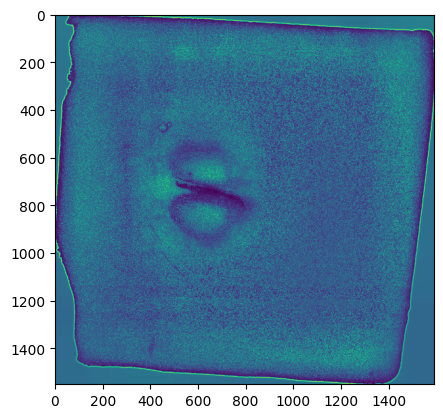

In [41]:
image_idx = 38
image_idx_str = str(image_idx).zfill(4)
image_path = f'/storage/valis_reg/BFIW_Block/original/{image_idx_str}.png'
mask_path =  f'/storage/valis_reg/rf_trained_pred/processed_mask/{image_idx_str}_mask.jpg'
image = cv2.imread(image_path)
adv_img = advanced_preprocessing(color_restored_img)
# entropy_img = entropy_filtering(image[:,:,1])
# entropy_img = frequency_domain_filter(entropy_img)
# plt.imshow(entropy_img)
plt.imshow(adv_img)

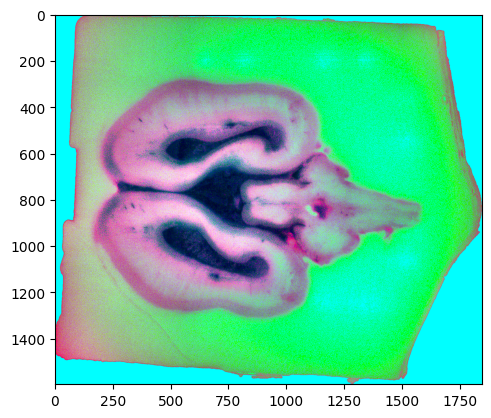

In [43]:
import cv2
import numpy as np
from skimage import exposure
from skimage import color
from skimage.util import img_as_ubyte

# Step 1: Convert image to LAB color space for color restoration
def convert_to_lab(image):
    """
    Convert the image from RGB to LAB color space.
    :param image: Input RGB image
    :return: Image in LAB color space
    """
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    return lab_image

# Step 2: Apply contrast stretching to the L (lightness) channel
def restore_lightness_channel(lab_image):
    """
    Stretch the contrast of the lightness (L) channel to reduce overexposure.
    :param lab_image: Image in LAB color space
    :return: LAB image with stretched L channel
    """
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    
    # Apply CLAHE to the L channel to reduce overexposure
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_channel_enhanced = clahe.apply(l_channel)
    
    # Merge back the LAB image
    lab_image_restored = cv2.merge((l_channel_enhanced, a_channel, b_channel))
    return lab_image_restored

# Step 3: Color normalization in LAB color space
def color_normalization(lab_image):
    """
    Normalize the A and B channels to restore chromatic information.
    :param lab_image: Image in LAB color space
    :return: LAB image with normalized A and B channels
    """
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    
    # Normalize A and B channels to reduce chromatic artifacts
    a_channel_normalized = cv2.normalize(a_channel, None, 0, 255, cv2.NORM_MINMAX)
    b_channel_normalized = cv2.normalize(b_channel, None, 0, 255, cv2.NORM_MINMAX)
    
    # Merge back the LAB image
    normalized_lab_image = cv2.merge((l_channel, a_channel_normalized, b_channel_normalized))
    return normalized_lab_image

# Step 4: Convert back to RGB for further processing
def lab_to_rgb(lab_image):
    """
    Convert the LAB image back to RGB after color normalization.
    :param lab_image: Input LAB image
    :return: Restored RGB image
    """
    rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)
    return rgb_image

# Step 5: Color Histogram Matching (Optional)
def match_histogram(source_image, reference_image):
    """
    Match the color histogram of the source image to that of the reference image.
    This is useful when you want to restore color balance from a reference.
    :param source_image: Image to be adjusted
    :param reference_image: Image whose color histogram is used as a reference
    :return: Color-matched image
    """
    matched_image = exposure.match_histograms(source_image, reference_image, multichannel=True)
    return img_as_ubyte(matched_image)

# Step 6: Apply Final ROI Accentuating (contrast stretching and sharpening)
def roi_accentuation(image):
    """
    Apply contrast stretching and sharpening to accentuate the ROI.
    :param image: Input image (RGB)
    :return: Image with enhanced contrast and sharpness
    """
    # Apply contrast stretching to increase distinction between regions
    p2, p98 = np.percentile(image, (2, 98))
    contrast_stretched = exposure.rescale_intensity(image, in_range=(p2, p98))
    
    # Apply sharpening filter to further enhance the ROI
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_image = cv2.filter2D(contrast_stretched, -1, kernel)
    
    return sharpened_image

# Main Function: Color restoration pipeline
def color_restoration_pipeline(image):
    """
    Main function to perform color restoration on an overexposed image.
    :param image: Input overexposed RGB image
    :return: Color-restored image
    """
    # Step 1: Convert to LAB color space
    lab_image = convert_to_lab(image)
    
    # Step 2: Restore the lightness channel (L)
    restored_lab_image = restore_lightness_channel(lab_image)
    
    # Step 3: Normalize chromatic channels (A and B)
    normalized_lab_image = color_normalization(restored_lab_image)
    
    # Step 4: Convert back to RGB after normalization
    restored_rgb_image = lab_to_rgb(normalized_lab_image)
    
    # Step 5: Optionally match the histogram to a reference (if you have one)
    # If no reference image is available, skip this step
    # reference_image = cv2.imread("reference_image.png")  # Load reference image
    # restored_rgb_image = match_histogram(restored_rgb_image, reference_image)
    
    # Step 6: Apply final ROI accentuation (contrast stretch + sharpening)
    final_image = roi_accentuation(restored_rgb_image)
    
    return final_image

image_idx = 1606
image_idx_str = str(image_idx).zfill(4)
image_path = f'/storage/valis_reg/BFIW_Block/original/{image_idx_str}.png'
image = cv2.imread(image_path)
color_restored_img = color_restoration_pipeline(image)
plt.imshow(color_restored_img)

/tmp/ipykernel_1959000/3065078953.py:55: RuntimeWarning: invalid value encountered in cast
  return np.uint8(lbp_image)


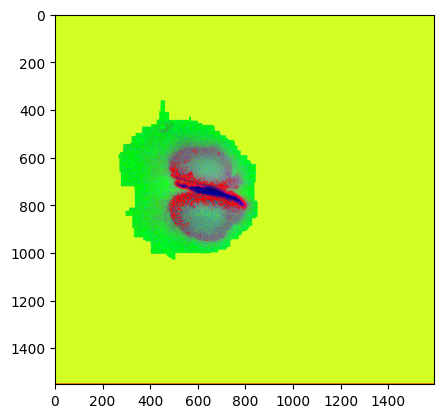

In [101]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from skimage import exposure

# Step 1: Retinex-Based Illumination Correction
def apply_retinex(image):
    """
    Apply a simplified retinex-based method for illumination correction.
    :param image: Input BGR image
    :return: Illumination-corrected image
    """
    # Convert the image to float and normalize to [0, 1]
    img_float = np.float32(image) / 255.0
    
    # Apply retinex to each channel (logarithmic domain)
    retinex_img = np.zeros_like(img_float)
    for i in range(3):  # Loop through RGB channels
        retinex_img[:, :, i] = np.log10(img_float[:, :, i] + 1e-6) - np.log10(cv2.GaussianBlur(img_float[:, :, i], (51, 51), 0) + 1e-6)
    
    # Normalize the output to [0, 255]
    retinex_img = np.uint8(cv2.normalize(retinex_img, None, 0, 255, cv2.NORM_MINMAX))
    
    return retinex_img

# Step 2: Non-Linear Intensity Masking for Overexposure
def intensity_mask(image):
    """
    Generate an intensity mask to identify overexposed regions in the image.
    :param image: Grayscale image
    :return: Binary mask of overexposed regions
    """
    # Threshold based on intensity to capture overexposed areas
    _, mask = cv2.threshold(image, 220, 255, cv2.THRESH_BINARY)
    
    # Optionally, apply a closing operation to fill gaps in the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

# Step 3: Texture Enhancement using Local Binary Patterns (LBP)
def apply_lbp(image):
    """
    Apply Local Binary Pattern (LBP) to enhance tissue textures.
    :param image: Grayscale image
    :return: LBP-enhanced image
    """
    # Use LBP with default parameters (8 neighbors, radius of 1)
    lbp_image = local_binary_pattern(image, P=8, R=2, method="var")
    
    # Normalize the LBP image for better visualization
    lbp_image = cv2.normalize(lbp_image, None, 0, 255, cv2.NORM_MINMAX)
    
    return np.uint8(lbp_image)

# Step 4: Combining Retinex, Masking, and LBP for Final Enhancement
def process_image(image):
    """
    Full processing pipeline combining Retinex-based correction, intensity masking,
    and LBP-based texture enhancement.
    :param image: Input BGR image
    :return: Processed image with enhanced tissue details
    """
    # Step 1: Apply Retinex for illumination correction
    retinex_image = apply_retinex(image)
    
    # Convert to grayscale for further processing
    grayscale_image = cv2.cvtColor(retinex_image, cv2.COLOR_BGR2GRAY)
    
    # Step 2: Generate intensity mask for overexposed areas
    overexposed_mask = intensity_mask(grayscale_image)
    
    # Step 3: Apply LBP to enhance texture details
    lbp_image = apply_lbp(grayscale_image)
    
    # Step 4: Combine the LBP texture with the original image and mask
    masked_lbp = cv2.bitwise_and(lbp_image, lbp_image, mask=overexposed_mask)
    
    # Step 5: Final output (fusing retinex and LBP)
    enhanced_image = cv2.addWeighted(grayscale_image, 0.3, masked_lbp, 0.7, 0)
    
    return enhanced_image

# Example usage
# if __name__ == "__main__":
    # Load the overexposed image (replace with actual path)
image_idx = 39
image_idx_str = str(image_idx).zfill(4)
image_path = f'/storage/valis_reg/rf_trained_pred/retinex/{image_idx_str}_retinex.jpg'
image = cv2.imread(image_path)
color_restored_img = color_restoration_pipeline(image)
# Process the image with the new method
processed_image = process_image(color_restored_img)
# plt.imshow(np.abs(color_restored_img[:,:,1]))
crimg = cv2.morphologyEx(color_restored_img[:,:,1], cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
# plt.imshow(crimg)
contours, _ = cv2.findContours(crimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.drawContours(color_restored_img, contours, -1, (255, 0, 0), 2)
plt.imshow(contour_img)

In [86]:
crimg.shape

(1550, 1591)

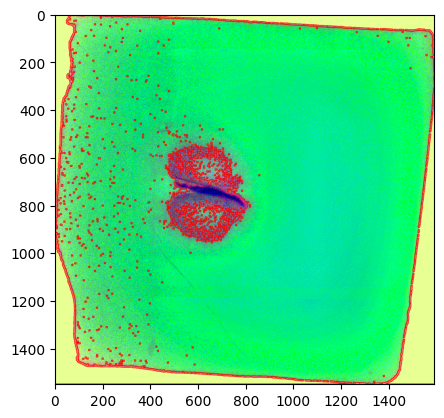

In [87]:
contours, _ = cv2.findContours(crimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.drawContours(color_restored_img, contours, -1, (255, 0, 0), 2)
plt.imshow(contour_img)

homomorphic_filter
fft_image
gaussian_high_pass
filtered_image
edge_preserving_filter
clahe
denoising


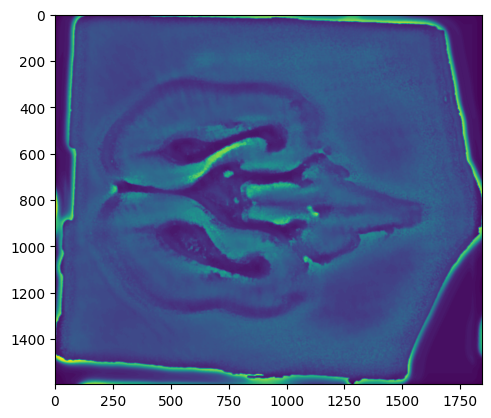

In [51]:
# Step 1: Color normalization and enhancement
def normalize_image(image):
    # Convert to LAB color space to isolate brightness
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab_image)
    
    # CLAHE to enhance contrast in the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # Merge back and convert to BGR
    limg = cv2.merge((cl, a, b))
    normalized_image = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    return normalized_image


# Step 1: Homomorphic Filtering for Illumination Correction
def homomorphic_filter(image, sigma=30):
    """
    Perform homomorphic filtering to correct uneven illumination in an image.
    :param image: Input image
    :param sigma: Sigma value for Gaussian filter in frequency domain
    :return: Illumination-corrected image
    """
    image_log = np.log1p(np.array(image, dtype="float") / 255)
    print('fft_image')
    # FFT of the image
    fft_image = fftpack.fft2(image_log)
    fft_image_shifted = fftpack.fftshift(fft_image)
    
    # Create a Gaussian high-pass filter
    rows, cols = image.shape[:2]
    crow, ccol = rows // 2, cols // 2
    x = np.linspace(-1, 1, cols)
    y = np.linspace(-1, 1, rows)
    X, Y = np.meshgrid(x, y)
    radius = np.sqrt((X ** 2) + (Y ** 2))
    gaussian_high_pass = 1 - np.exp(-(radius ** 2) / (2 * (sigma / max(rows, cols)) ** 2))
    print('gaussian_high_pass')
    # Apply the high-pass filter
    filtered_fft_image = fft_image_shifted * gaussian_high_pass
    filtered_fft_image_shifted = fftpack.ifftshift(filtered_fft_image)
    filtered_image = fftpack.ifft2(filtered_fft_image_shifted)
    print('filtered_image')
    # Take the exponential and scale back to original range
    image_filtered = np.exp(np.real(filtered_image)) - 1
    image_filtered = np.uint8(np.clip(image_filtered * 255, 0, 255))
    
    return image_filtered

# Step 2: Edge-Preserving Filtering (Bilateral Filtering)
def edge_preserving_filter(image):
    """
    Use bilateral filtering to preserve edges while reducing overexposure.
    :param image: Input image
    :return: Edge-preserving filtered image
    """
    # Bilateral filter to smooth image while preserving edges
    filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    return filtered_image

# Step 3: Advanced Preprocessing Function
def advanced_preprocessing(image):
    """
    Advanced preprocessing to correct overexposure, diffraction, and enhance tissue contrast.
    :param image: Input image
    :return: Preprocessed image
    """
    # Step 1: Convert to grayscale if the image is in color
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image
    print('homomorphic_filter')
    # Step 2: Homomorphic filtering for illumination correction
    illumination_corrected = homomorphic_filter(image_gray)
    print('edge_preserving_filter')
    # Step 3: Bilateral filtering for edge preservation and overexposure reduction
    filtered_image = edge_preserving_filter(illumination_corrected)
    print('clahe')  
    # Step 4: Contrast enhancement using adaptive histogram equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(filtered_image)
    print('denoising')
    # Step 5: Denoising to smooth any high-frequency noise
    denoised_image = restoration.denoise_bilateral(contrast_enhanced, sigma_color=0.05, sigma_spatial=15)
    
    return np.uint8(denoised_image * 255)

image_idx = 38
image_idx_str = str(image_idx).zfill(4)
image_path = f'/storage/valis_reg/rf_trained_pred/original/{image_idx_str}_original.jpg'
image_path = f'/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_{image_idx}_original.jpg'
image_path = f'/storage/valis_reg/BFIW_Block/original/{image_idx_str}.png'
mask_path =  f'/storage/valis_reg/rf_trained_pred/processed_mask/{image_idx_str}_mask.jpg'
image = cv2.imread(image_path)
# image = normalize_image(image)
# plt.imshow(image)

def segment_tissue(img_array):
    """
    Segments the tissue region from the preprocessed image.

    Args:
        img: Preprocessed SimpleITK Image object.

    Returns:
        Binary mask of the tissue region as a SimpleITK Image object.
    """
    # img_array = sitk.GetArrayFromImage(img)

    # Thresholding (experiment with different methods)
    thresh = img_array > np.mean(img_array)  # Simple thresholding

    # Morphological operations to clean up the mask
    thresh = morphology.remove_small_objects(thresh, 200)  # Remove small noise
    thresh = morphology.closing(thresh, morphology.disk(3))  # Close small holes

    # Extract contours and fill them
    contours = measure.find_contours(thresh, 0.5)
    filled_mask = np.zeros_like(thresh).astype(np.uint8)
    for contour in contours:
        cv2.fillPoly(filled_mask, pts=[contour.astype(int)], color=1)

    return sitk.GetImageFromArray(filled_mask.astype(np.uint8))


adv_img = advanced_preprocessing(color_restored_img)

plt.imshow(adv_img)


In [198]:
def preprocess_image(image_path):
    """
    Loads, enhances tissue regions using adaptive thresholding, and removes background noise.

    Args:
        image_path: Path to the image file.

    Returns:
        Preprocessed image as a SimpleITK Image object.
    """
    img = sitk.ReadImage(image_path)
    img_array = sitk.GetArrayFromImage(img)
    img_array = (img_array*255).astype(np.uint8)
    # img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    # Convert to HSV color space (assuming the image is in RGB)
    hsv_img = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)

    # Enhance saturation channel (adjust as needed)
    # hsv_img[:, :, 0] = exposure.equalize_hist(hsv_img[:, :, 0]) 
    hsv_img[:, :, 1] = exposure.equalize_hist(hsv_img[:, :, 1]) 
    # hsv_img[:, :, 2] = exposure.equalize_hist(hsv_img[:, :, 2]) 

    # Convert back to RGB (optional)
    enhanced_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    # enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2GRAY)
    img_array = enhanced_img[:,:,1]

    # Edge detection (Canny edge detector)
    edges = cv2.Canny(img_array.astype(np.uint8), threshold1=50, threshold2=75, apertureSize=3, L2gradient=True)

    # Refine seed points (morphological opening)
    opened_edges = morphology.binary_opening(edges, morphology.disk(5))
    seeds = np.column_stack(np.where(opened_edges != 0))

    # Region growing (seed points from refined edge image)
    markers = np.zeros_like(img_array)
    markers[seeds[:, 0], seeds[:, 1]] = 1
    mask = morphology.label(morphology.isotropic_dilation(edges, 5))
    filled_mask = segmentation.watershed(-img_array, mask,2, mask=edges, watershed_line=True) > 0
    filled_mask = cv2.dilate(filled_mask.astype(np.uint8), np.ones((3, 3), np.uint8), iterations=2)
    filled_mask = cv2.morphologyEx(filled_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=5)
    return sitk.GetImageFromArray(filled_mask.astype(np.uint8))

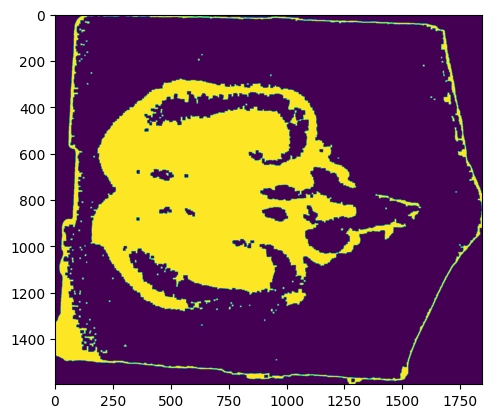

In [201]:
image_idx = 1598
image_idx_str = str(image_idx).zfill(4)
image_path = f'/storage/valis_reg/rf_trained_pred/original/{image_idx_str}_original.jpg'
image_path = f'/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_{image_idx}_original.jpg'
image_path = f'/storage/valis_reg/BFIW_Block/msrcr/{image_idx_str}.png'
mask_path =  f'/storage/valis_reg/rf_trained_pred/processed_mask/{image_idx_str}_mask.jpg'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask[mask > 0] = 1
img = preprocess_image(image_path)
img_array = (sitk.GetArrayFromImage(img)*255).astype(np.uint8)
# masked = cv2.bitwise_and(img_array, img_array, mask=mask)
plt.imshow(img_array)

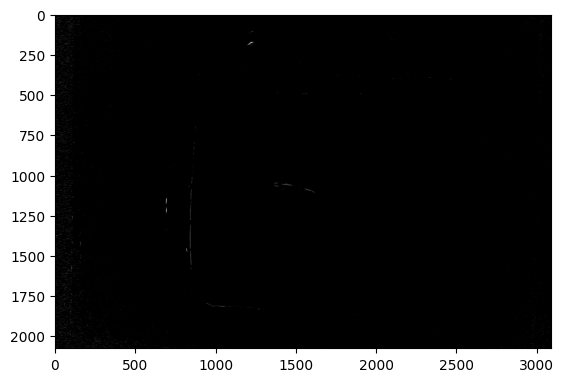

In [76]:
img_array = (sitk.GetArrayFromImage(img)*255).astype(np.uint8)
# masked = cv2.bitwise_and(img_array, img_array, mask=mask)
plt.imshow(img_array)
# plt.imshow(masked[:,:,1], cmap='jet')

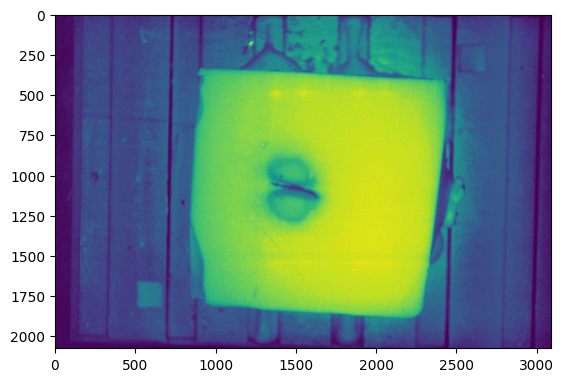

In [65]:
masked_LAB = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
plt.imshow(masked_LAB)

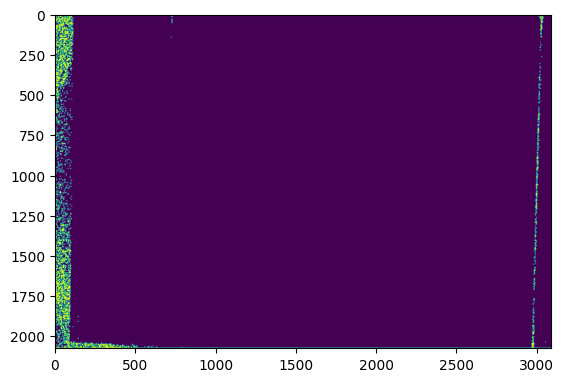

In [69]:
contours, _ = cv2.findContours(img_array[:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
blank = np.zeros_like(masked_LAB)
plt.imshow(cv2.drawContours(blank, contours, -1, (255), 2))

## Tissue Segmentation

In [3]:
def segment_tissue(img):
    """
    Segments the tissue region from the preprocessed image.

    Args:
        img: Preprocessed SimpleITK Image object.

    Returns:
        Binary mask of the tissue region as a SimpleITK Image object.
    """
    img_array = sitk.GetArrayFromImage(img)

    # Thresholding (experiment with different methods)
    thresh = img_array > np.mean(img_array)  # Simple thresholding

    # Morphological operations to clean up the mask
    thresh = morphology.remove_small_objects(thresh, 200)  # Remove small noise
    thresh = morphology.closing(thresh, morphology.disk(3))  # Close small holes

    # Extract contours and fill them
    contours = measure.find_contours(thresh, 0.5)
    filled_mask = np.zeros_like(thresh)
    for contour in contours:
        cv2.fillPoly(filled_mask, pts=[contour.astype(int)], color=1)

    return sitk.GetImageFromArray(filled_mask.astype(np.uint8))

Image Registration

In [4]:
def register_images(fixed_img, moving_img):
    """
    Performs rigid registration between two images.

    Args:
        fixed_img: Fixed SimpleITK Image object.
        moving_img: Moving SimpleITK Image object.

    Returns:
        Registered moving image as a SimpleITK Image object.
    """
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_img, moving_img, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()
    registration_method.SetInitialTransform(initial_transform)

    final_transform = registration_method.Execute(fixed_img, moving_img)

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_img)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetTransform(final_transform)

    return resampler.Execute(moving_img)

Pipeline Integration

In [5]:
def process_and_align_images(image_paths):
    """
    Processes and aligns a set of brain slice images.

    Args:
        image_paths: List of paths to the image files.

    Returns:
        List of aligned tissue masks as SimpleITK Image objects.
    """
    aligned_masks = []

    # Process the first image as the fixed image
    fixed_img = preprocess_image(image_paths[0])
    fixed_mask = segment_tissue(fixed_img)
    aligned_masks.append(fixed_mask)

    # Process and register subsequent images
    for image_path in image_paths[1:]:
        moving_img = preprocess_image(image_path)
        moving_mask = segment_tissue(moving_img)

        registered_mask = register_images(fixed_img, moving_img)
        aligned_masks.append(registered_mask)

    return aligned_masks

3D Reconstruction

In [6]:
def reconstruct_3d(aligned_masks):
    """
    Reconstructs a 3D volume from the aligned masks.

    Args:
        aligned_masks: List of aligned tissue masks as SimpleITK Image objects.
    """
    # Stack the masks into a 3D volume
    volume = sitk.JoinSeries(aligned_masks)

    # Visualize or save the 3D volume (optional)
    sitk.Show(volume)

    Stain separation matrices available in the ``color`` module and their
    respective colorspace:

    * ``hed_from_rgb``: Hematoxylin + Eosin + DAB
    * ``hdx_from_rgb``: Hematoxylin + DAB
    * ``fgx_from_rgb``: Feulgen + Light Green
    * ``bex_from_rgb``: Giemsa stain : Methyl Blue + Eosin
    * ``rbd_from_rgb``: FastRed + FastBlue +  DAB
    * ``gdx_from_rgb``: Methyl Green + DAB
    * ``hax_from_rgb``: Hematoxylin + AEC
    * ``bro_from_rgb``: Blue matrix Anilline Blue + Red matrix Azocarmine\
                        + Orange matrix Orange-G
    * ``bpx_from_rgb``: Methyl Blue + Ponceau Fuchsin
    * ``ahx_from_rgb``: Alcian Blue + Hematoxylin
    * ``hpx_from_rgb``: Hematoxylin + PAS

In [1]:
from skimage.color.colorconv import ahx_from_rgb,hpx_from_rgb,bpx_from_rgb,bro_from_rgb,hax_from_rgb,gdx_from_rgb,rbd_from_rgb,bex_from_rgb,fgx_from_rgb,hdx_from_rgb,hed_from_rgb,separate_stains
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi

In [2]:
def read_img_mask(image_idx, original=False):
    if original:
        retinex_path = f'rf_trained_pred/original/{str(image_idx).zfill(4)}_original.jpg'
    else:
        retinex_path = f'rf_trained_pred/retinex/{str(image_idx).zfill(4)}_retinex.jpg'
    mask_path = f'rf_trained_pred/processed_mask/{str(image_idx).zfill(4)}_mask.jpg'
    mask2_path = f'rf_trained_pred/raw_mask/{str(image_idx).zfill(4)}_raw_mask.jpg'
    image = cv2.imread(retinex_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask[mask > 0] = 1
    mask2 = cv2.imread(mask2_path, cv2.IMREAD_GRAYSCALE)
    mask2[mask2 > 0] = 1
    return image, mask, mask2

def extract_img(image, mask):
    return cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))

def process_channel(channel):
    channel[channel>0]=1
    channel = cv2.dilate(channel, np.ones((3,3), np.uint8), iterations=1)
    channel = ndi.binary_fill_holes(channel)
    # channel = cv2.erode(channel, np.ones((3,3), np.uint8), iterations=5)
    channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_HITMISS, np.ones((3,3), np.uint8), iterations=5)
    channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_CROSS, np.ones((3,3), np.uint8), iterations=5)
#     channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_GRADIENT, np.ones((3,3), np.uint8), iterations=5)
    channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
    channel = ndi.binary_fill_holes(channel)
    channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=20)
    # channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
    # channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_CROSS, np.ones((3,3), np.uint8), iterations=5)
    return channel

def plot_channels(image, channels):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, (channel, name) in enumerate(zip(cv2.split(channels), ["C1", "C2", "C3"])):
        channel = process_channel(channel)
        channel = extract_img(image, channel)
        axes[i].imshow(channel)
        axes[i].set_title(f'{name} Channel ({channel.min()}-{channel.max()})')
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

def process_rf_mask(mask):
    mask = mask.astype(np.uint8)
    mask = ndi.binary_fill_holes(mask)
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=5)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
    return mask

def plot_current_masks(image, mask, mask2):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    proc_mask = extract_img(image, mask)
    axes[0].imshow(proc_mask)
    axes[0].set_title("Processed Mask")
    axes[0].axis("off")
    rf_mask = process_rf_mask(mask2)
    rf_mask = extract_img(image, rf_mask)
    axes[1].imshow(rf_mask)
    axes[1].set_title("Raw Mask")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()
    
def get_stain_vector(StainingVectorID):
       """
       StainingVectorID: Index
       1  = "H&E"
       2  = "H&E 2"
       3  = "H DAB"
       4  = "H&E DAB"
       5  = "NBT/BCIP Red Counterstain II"
       6  = "H DAB NewFuchsin"
       7  = "H HRP-Green NewFuchsin"
       8  = "Feulgen LightGreen"
       9  = "Giemsa"
       10 = "FastRed FastBlue DAB"
       11 = "Methyl Green DAB"
       12 = "H AEC"
       13 = "Azan-Mallory"
       14 = "Masson Trichrome"
       15 = "Alcian Blue & H"
       16 = "H PAS"
       17 = "Brilliant_Blue"
       18 = "AstraBlue Fuchsin"
       19 = "RGB"
       20 = "ROI Based Extraction"
       """
       if StainingVectorID==1:
              MODx = [0.644211, 0.092789, 0];
              MODy = [0.716556, 0.954111, 0];
              MODz = [0.266844, 0.283111, 0];
       elif StainingVectorID==2:
              MODx = [0.49015734, 0.04615336, 0];
              MODy = [0.76897085, 0.8420684, 0];
              MODz = [0.41040173, 0.5373925, 0];
       elif StainingVectorID==3:
              MODx = [0.650, 0.268, 0];
              MODy = [0.704, 0.570, 0];
              MODz = [0.286, 0.776, 0];
       elif StainingVectorID==4:
              MODx = [0.650, 0.072, 0.268];
              MODy = [0.704, 0.990, 0.570];
              MODz = [0.286, 0.105, 0.776];
       elif StainingVectorID==5:
              MODx = [0.62302786, 0.073615186, 0.7369498];
              MODy = [0.697869, 0.79345673, 0.0010];
              MODz = [0.3532918, 0.6041582, 0.6759475];
       elif StainingVectorID==6:
              MODx = [0.5625407925, 0.26503363, 0.0777851125];
              MODy = [0.70450559, 0.68898016, 0.804293475];
              MODz = [0.4308375625, 0.674584, 0.5886050475];
       elif StainingVectorID==7:
              MODx = [0.8098939567, 0.0777851125, 0.0];
              MODy = [0.4488181033, 0.804293475, 0.0];
              MODz = [0.3714423567, 0.5886050475, 0.0];
       elif StainingVectorID==8:
              MODx = [0.46420921, 0.94705542, 0.0];
              MODy = [0.83008335, 0.25373821, 0.0];
              MODz = [0.30827187, 0.19650764, 0.0];
       elif StainingVectorID==9:
              MODx = [0.834750233, 0.092789, 0.0];
              MODy = [0.513556283, 0.954111, 0.0];
              MODz = [0.196330403, 0.283111, 0.0];
       elif StainingVectorID==10:
              MODx = [0.21393921, 0.74890292, 0.268];
              MODy = [0.85112669, 0.60624161, 0.570];
              MODz = [0.47794022, 0.26731082, 0.776];
       elif StainingVectorID==11:
              MODx = [0.98003, 0.268, 0.0];
              MODy = [0.144316, 0.570, 0.0];
              MODz = [0.133146, 0.776, 0.0];
       elif StainingVectorID==12:
              MODx = [0.650, 0.2743, 0.0];
              MODy = [0.704, 0.6796, 0.0];
              MODz = [0.286, 0.6803, 0.0];
       elif StainingVectorID==13:
              MODx = [0.853033, 0.09289875, 0.10732849];
              MODy = [0.508733, 0.8662008, 0.36765403];
              MODz = [0.112656, 0.49098468, 0.9237484];
       elif StainingVectorID==14:
              MODx = [0.7995107, 0.09997159, 0.0];
              MODy = [0.5913521, 0.73738605, 0.0];
              MODz = [0.10528667, 0.6680326, 0.0];
       elif StainingVectorID==15:
              MODx = [0.874622, 0.552556, 0.0];
              MODy = [0.457711, 0.7544, 0.0];
              MODz = [0.158256, 0.353744, 0.0];
       elif StainingVectorID==16:
              MODx = [0.644211, 0.175411, 0.0];
              MODy = [0.716556, 0.972178, 0.0];
              MODz = [0.266844, 0.154589, 0.0];
       elif StainingVectorID==17:
              MODx = [0.31465548, 0.383573, 0.7433543];
              MODy = [0.6602395, 0.5271141, 0.51731443];
              MODz = [0.68196464, 0.7583024, 0.4240403];
       elif StainingVectorID==18:
              MODx = [0.92045766, 0.13336428, 0.0];
              MODy = [0.35425216, 0.8301452, 0.0];
              MODz = [0.16511545, 0.5413621, 0.0];
       elif StainingVectorID==19:
              MODx = [0.001, 1.0, 1.0];
              MODy = [1.0, 0.001, 1.0];
              MODz = [1.0, 1.0, 0.001];
       elif StainingVectorID==20:
              MODx =[ 0.22777562, 0.55556387, 0.7996668 ]
              MODy =[0.035662863,  0.08113831, 0.9960646]
              MODz =[ 0.7617831, 0.6478321 ,  0.001]
       else:
              MODx = [1.0, 0.0, 0.0];
              MODy = [0.0, 1.0, 0.0];
              MODz = [0.0, 0.0, 1.0];
       eps = 1e-5
       stain_vectors = np.array([MODx, MODy, MODz]).T
       # Check 2nd Channel is missing
       if all([x==0.0 for x in stain_vectors[1,:]]):
              stain_vectors[1,:] = stain_vectors[0,:][[2,0,1]]
       # Check 3rd Channel is missing
       if all([x==0.0 for x in stain_vectors[2,:]]):
              stain_vectors[2,:] = np.cross(stain_vectors[0,:] , stain_vectors[1,:])
       return np.linalg.inv(stain_vectors)

def background_removal_dog(brightfield_img, kernel1=15, kernel2=50):
    """Remove background using the Difference of Gaussian (DoG) method."""
    # Apply Gaussian blur with two different kernel sizes
    blurred1 = cv2.GaussianBlur(brightfield_img, (kernel1, kernel1), 0)
    blurred2 = cv2.GaussianBlur(brightfield_img, (kernel2, kernel2), 0)
    
    # Subtract the two blurred images (Difference of Gaussians)
    dog_result = blurred1 - blurred2
    
    # Threshold to isolate the foreground
    _, binarized_foreground = cv2.threshold(dog_result, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)
    
    return binarized_foreground


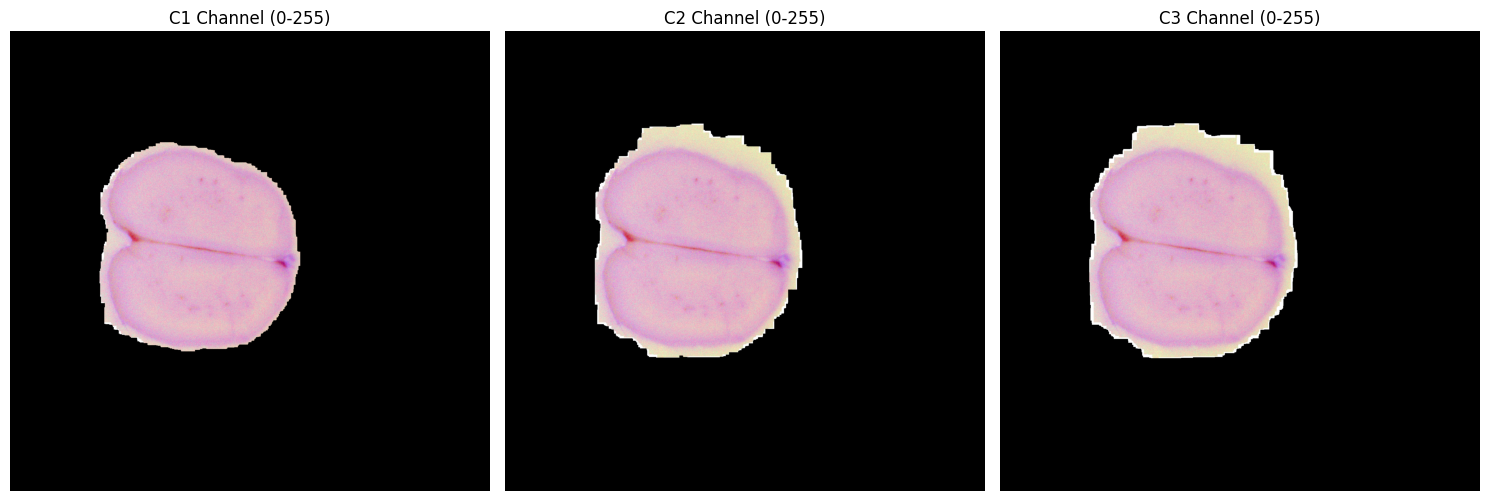

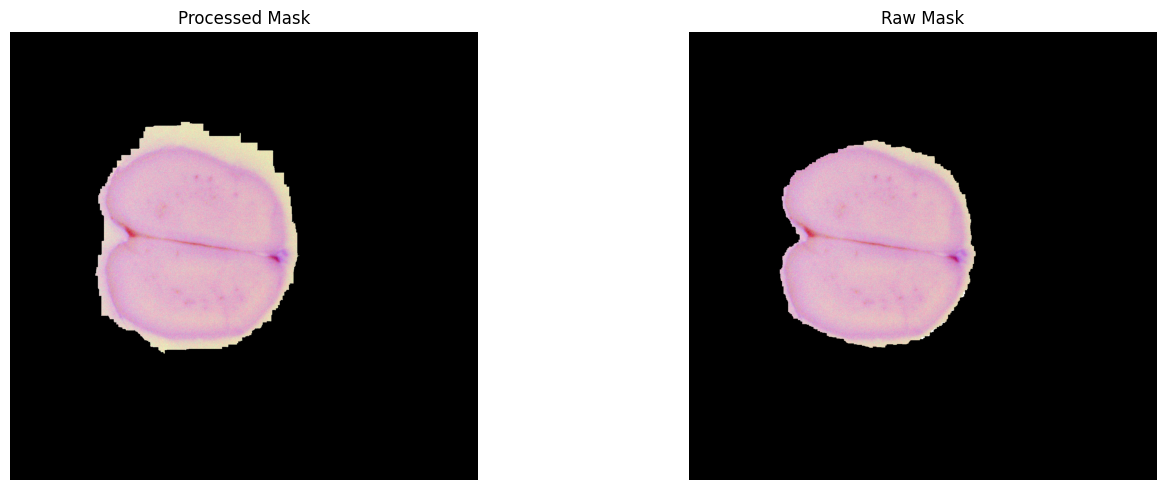

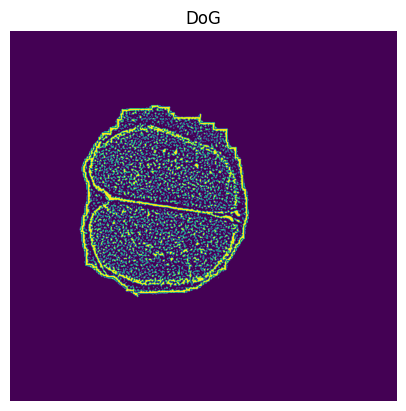

In [3]:
image_idx=213

image, mask, mask2 = read_img_mask(image_idx, original=False)
channels = separate_stains(image, get_stain_vector(10))
plot_channels(image, channels)
plot_current_masks(image, mask, mask2)
ddog = background_removal_dog(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY),15,27)
plt.imshow(ddog)
plt.title('DoG')
plt.axis('off')
plt.show()

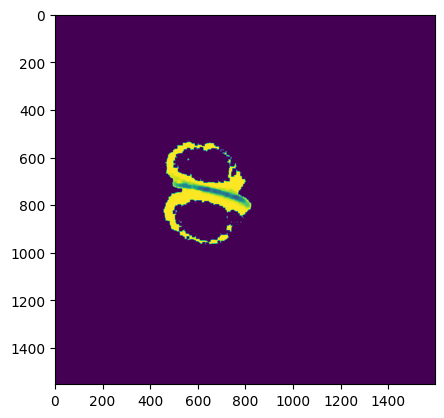

In [63]:
(np.min(image,axis=2)/255)
image_idx=55

image, mask, mask2 = read_img_mask(image_idx, original=False)
np.percentile(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)/255, [0, 2, 4, 8, 20])
im_min = np.min(image,axis=2)/255
im_min[im_min>0.6]=0
im_min = (im_min*255).astype(np.uint8)
# im_min = cv2.dilate(im_min, np.ones((3,3), np.uint8), iterations=2)
im_min = cv2.morphologyEx(im_min.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
# im_min = ndi.binary_fill_holes(im_min)
plt.imshow(im_min)

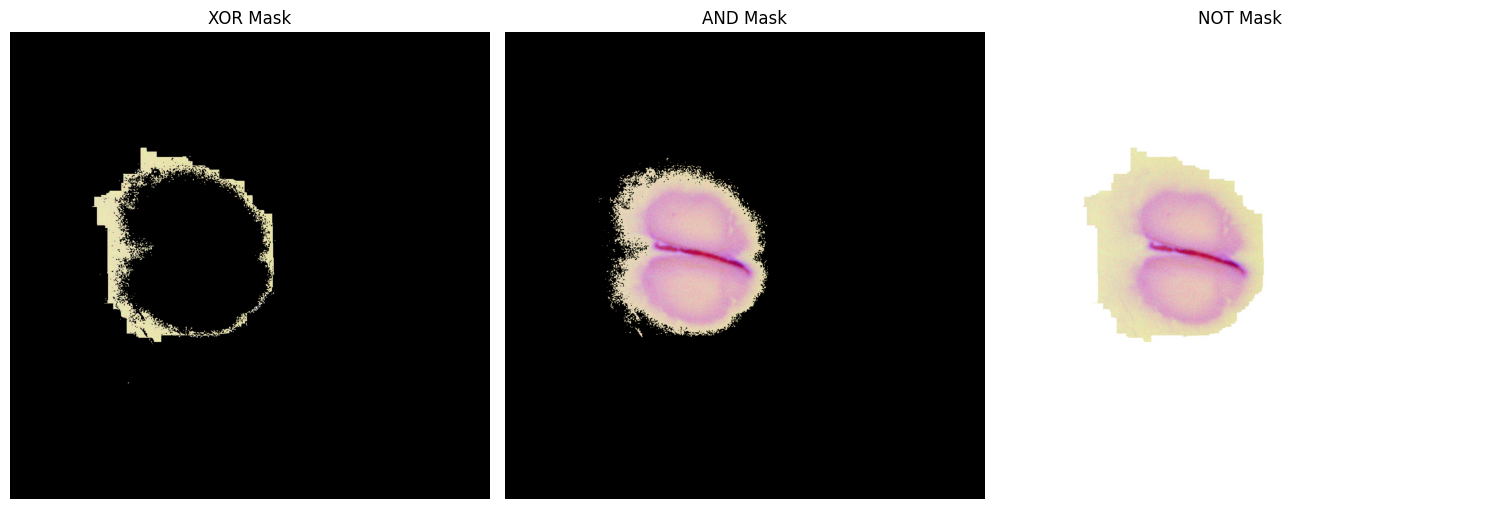

In [9]:
image_idx=55

image, mask, mask2 = read_img_mask(image_idx, original=False)
mask_xor = np.bitwise_xor(mask, mask2)
mask_and = np.bitwise_and(mask, mask2)
mask_not = np.bitwise_not(mask)
image_trim_xor = cv2.bitwise_and(image, image, mask=mask_xor.astype(np.uint8))
image_trim_and = cv2.bitwise_and(image, image, mask=mask_and.astype(np.uint8))
image_trim_not = cv2.bitwise_and(image, image, mask=mask_not.astype(np.uint8))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_trim_xor)
axes[0].set_title("XOR Mask")
axes[0].axis("off")
axes[1].imshow(image_trim_and)
axes[1].set_title("AND Mask")
axes[1].axis("off")
axes[2].imshow(image_trim_not)
axes[2].set_title("NOT Mask")
axes[2].axis("off")
plt.tight_layout()
plt.show()
# image_trim = cv2.morphologyEx(image_trim, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=5)
# plt.imshow(np.min(image_trim, axis=2))

In [32]:
im_min = np.min(image,axis=2)/255
threshold = 1.0
((im_min < threshold).mean() + (im_min <= threshold).mean()) / 2

0.5595752501020742

In [36]:
 np.arange(0, 100, 10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [57]:
image, mask, mask2 = read_img_mask(image_idx, original=False)
im_min = np.min(image,axis=2)/255
np.percentile(im_min[mask==1], np.arange(0, 100, 5))

array([0.        , 0.58039216, 0.60784314, 0.61568627, 0.62352941,
       0.63137255, 0.63529412, 0.63921569, 0.64313725, 0.64705882,
       0.65098039, 0.65490196, 0.65882353, 0.6627451 , 0.66666667,
       0.6745098 , 0.67843137, 0.68235294, 0.69019608, 0.69803922])

In [37]:
np.percentile(im_min[mask==0], np.arange(0, 110, 10))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

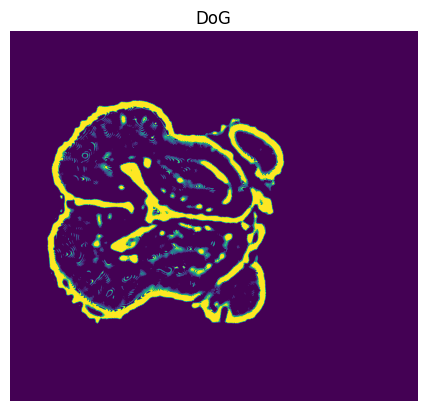

In [214]:
ddog = background_removal_dog(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY),55,67)
plt.imshow(ddog)
plt.title('DoG')
plt.axis('off')
plt.show()

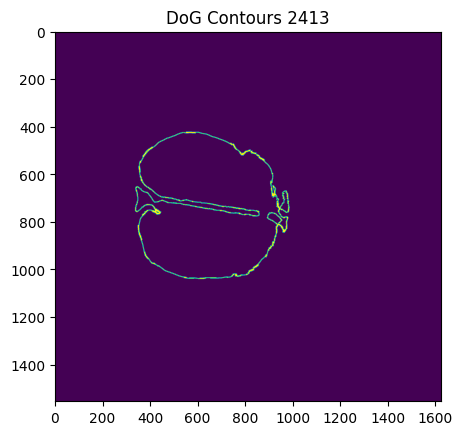

In [85]:
# ddog = background_removal_dog(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY),15,27)
contours,_ = cv2.findContours(ddog, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
blank = np.zeros_like(ddog, dtype=np.uint8)

contour_img = cv2.drawContours(blank, contours, 1, 1, 2)
plt.imshow(contour_img)
plt.title(f'DoG Contours {len(contours)}')
plt.show()

In [310]:
import os
import cv2
brightfield = os.listdir('213_BFIW/BFIW/')
darkfield = os.listdir('213_BFIW/BFI/')
brightfield = sorted(brightfield, key=lambda x: int(x.replace('_original.jpg','').split('_')[-1]))
darkfield = sorted(darkfield, key=lambda x: int(x.replace('_original.jpg','').split('_')[-1]))
slides = {}
for bf, df in zip(brightfield, darkfield):
    idx = bf.replace('_original.jpg','').split('_')[-1]
    slides[int(idx)] = {'brightfield': bf, 'darkfield': df}

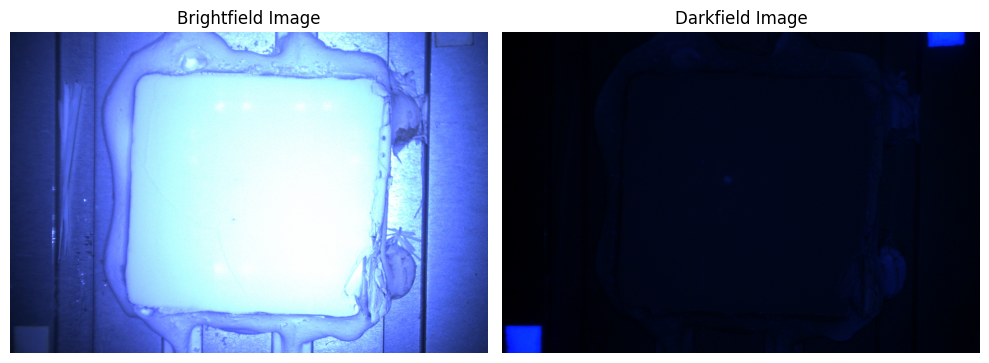

In [402]:
slide_idx = 2655
bfiw = slides[slide_idx]['brightfield']
bfi = slides[slide_idx]['darkfield']
flatfield_bfiw_img = cv2.imread(f'213_BFIW/BFIW/{bfiw}')
flatfield_bfi_img = cv2.imread(f'213_BFIW/BFI/{bfi}')
flatfield_bfiw_img = cv2.cvtColor(flatfield_bfiw_img, cv2.COLOR_BGR2RGB)
flatfield_bfi_img = cv2.cvtColor(flatfield_bfi_img, cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(flatfield_bfiw_img)
axes[0].set_title('Brightfield Image')
axes[0].axis('off')
axes[1].imshow(flatfield_bfi_img)
axes[1].set_title('Darkfield Image')
axes[1].axis('off')
plt.tight_layout()

In [355]:
specimen = 1185
bfiw = slides[specimen]['brightfield']
bfi = slides[specimen]['darkfield']
specimen_bfiw_img = cv2.imread(f'213_BFIW/BFIW/{bfiw}')
specimen_bfi_img = cv2.imread(f'213_BFIW/BFI/{bfi}')
specimen_bfiw_img = cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_BGR2RGB)
specimen_bfi_img = cv2.cvtColor(specimen_bfi_img, cv2.COLOR_BGR2RGB)

In [374]:
corrs = ((specimen_bfiw_img - specimen_bfi_img)/ (flatfield_bfiw_img - specimen_bfi_img)) *255
corrs = corrs.astype(np.uint8).clip(0, 255)

/tmp/ipykernel_1992170/91485844.py:1: RuntimeWarning: divide by zero encountered in divide
  corrs = ((specimen_bfiw_img - specimen_bfi_img)/ (bfiw_img - specimen_bfi_img)) *255
/tmp/ipykernel_1992170/91485844.py:1: RuntimeWarning: invalid value encountered in divide
  corrs = ((specimen_bfiw_img - specimen_bfi_img)/ (bfiw_img - specimen_bfi_img)) *255
/tmp/ipykernel_1992170/91485844.py:2: RuntimeWarning: invalid value encountered in cast
  corrs = corrs.astype(np.uint8).clip(0, 255)


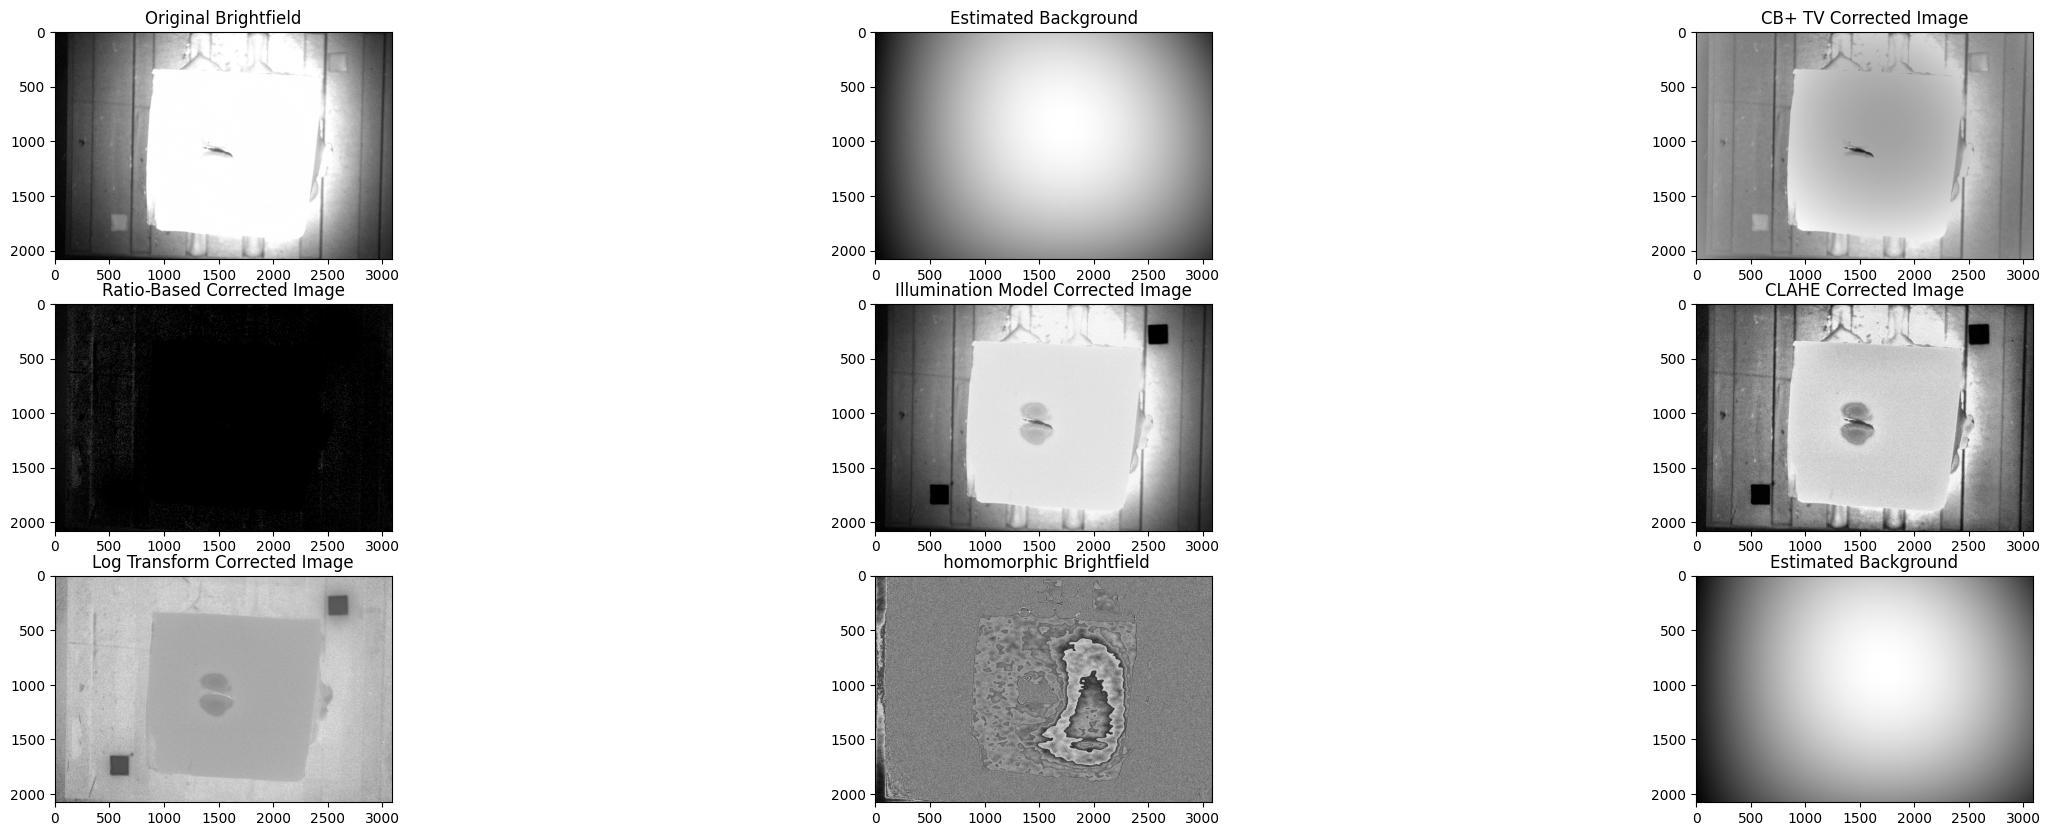

In [390]:
import numpy as np
import cv2
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle


def poly_surface(x, y, *coeffs):
    """Define a 2D polynomial surface."""
    order = int(np.sqrt(len(coeffs)) - 1)
    z = sum([coeffs[i] * (x**(order - i//(order+1))) * (y**(i%(order+1))) for i in range(len(coeffs))])
    return z

def background_estimation(img, mask, order=5):
    """Estimate background illumination using polynomial surface fitting, with masking."""
    h, w = img.shape
    x, y = np.meshgrid(np.arange(w), np.arange(h))

    # Use only masked regions for polynomial fitting (i.e., dark areas in darkfield image)
    valid_pixels = mask.ravel() == 0
    popt, _ = curve_fit(lambda data, *params: poly_surface(data[0], data[1], *params),
                        (x.ravel()[valid_pixels], y.ravel()[valid_pixels]), img.ravel()[valid_pixels], p0=np.ones((order+1)**2))

    background = poly_surface(x, y, *popt).reshape(h, w)
    return background

def correct_background(brightfield_img, darkfield_img, order=2):
    """Correct background in brightfield image using darkfield as a mask."""
    # Create a mask from the darkfield image (invert it to find background areas)
    darkfield_mask = cv2.threshold(darkfield_img, 0, 255, cv2.THRESH_BINARY)[1]

    # Estimate background illumination in the brightfield image
    background = background_estimation(brightfield_img, darkfield_mask, order=order)

    # Subtract the estimated background from the brightfield image
    corrected_img = brightfield_img - background

    return corrected_img, background


def total_variation_correction(img, weight=0.1):
    """Use total variation minimization to correct illumination."""
    tv_corrected = denoise_tv_chambolle(img, weight=weight)
    return tv_corrected

def ratio_based_correction(brightfield_img, darkfield_img):
    """Apply ratio-based correction using both brightfield and darkfield images."""
    # Normalize images to avoid division by zero
    brightfield_img = brightfield_img.astype(np.float32)
    darkfield_img = darkfield_img.astype(np.float32)

    # Add a small constant to avoid division by zero
    epsilon = 1e-5

    # Compute the ratio between brightfield and darkfield
    ratio_img = brightfield_img / (darkfield_img + epsilon)

    # Normalize the ratio to the original intensity range
    corrected_img = cv2.normalize(ratio_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return corrected_img


def illumination_model_correction(brightfield_img, darkfield_img):
    """Model background illumination using the darkfield image and correct the brightfield image."""
    # Normalize darkfield to represent the background illumination
    background_model = cv2.normalize(darkfield_img, None, 0, np.max(brightfield_img), cv2.NORM_MINMAX)
    
    # Subtract the modeled illumination from the brightfield image
    corrected_img = cv2.subtract(brightfield_img, background_model)
    
    return corrected_img

def clahe_correction(brightfield_img, darkfield_img):
    """Apply CLAHE after darkfield subtraction for background correction."""
    # Subtract darkfield image from brightfield
    subtracted_img = cv2.subtract(brightfield_img, darkfield_img)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    corrected_img = clahe.apply(subtracted_img)

    return corrected_img

def log_transform_correction(brightfield_img, darkfield_img):
    """Apply logarithmic transformation with darkfield compensation for background correction."""
    # Normalize the darkfield image
    darkfield_img_normalized = cv2.normalize(darkfield_img, None, 1, 255, cv2.NORM_MINMAX)

    # Add a small constant to avoid log(0)
    epsilon = 1e-5

    # Apply logarithmic transformation on the brightfield image
    brightfield_log = np.log1p(brightfield_img.astype(np.float32) + epsilon)

    # Subtract darkfield information
    darkfield_log = np.log1p(darkfield_img_normalized.astype(np.float32) + epsilon)

    # Combine the images and normalize
    corrected_img = brightfield_log - darkfield_log
    corrected_img = cv2.normalize(corrected_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return corrected_img


def homomorphic_filter(image, low=0.5, high=2.0):
    rows, cols = image.shape
    img_log = np.log1p(np.array(image, dtype="float"))

    dft = np.fft.fft2(img_log)
    dft_shift = np.fft.fftshift(dft)

    # Create high-pass filter
    crow, ccol = rows // 2 , cols // 2
    mask = np.ones((rows, cols), np.float32)
    r = 30
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = np.exp(-(((x - center[0]) ** 2 + (y - center[1]) ** 2) / (2.0 * r * r)))

    # Apply homomorphic filter
    dft_shift = (low + (high - low) * mask_area) * dft_shift
    dft_shift = np.fft.ifftshift(dft_shift)
    img_back = np.fft.ifft2(dft_shift)
    img_back = np.expm1(np.real(img_back))
    
    return np.uint8(img_back)

specimen = 38
bfiw = slides[specimen]['brightfield']
bfi = slides[specimen]['darkfield']
specimen_bfiw_img = cv2.imread(f'213_BFIW/BFIW/{bfiw}')
specimen_bfi_img = cv2.imread(f'213_BFIW/BFI/{bfi}')
specimen_bfiw_img = cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_BGR2RGB)
specimen_bfi_img = cv2.cvtColor(specimen_bfi_img, cv2.COLOR_BGR2RGB)

# Load images
brightfield_img = specimen_bfiw_img[:,:,2]  # Brightfield image (grayscale)
darkfield_img = specimen_bfi_img[:,:,2]     # Darkfield image (grayscale)

# Apply polynomial surface fitting with darkfield masking
cb_corrected_img, background = correct_background(brightfield_img, darkfield_img)
rbc_corrected_img = ratio_based_correction(brightfield_img, darkfield_img)

# Apply illumination model correction
imc_corrected_img = illumination_model_correction(brightfield_img, darkfield_img)
clahe_corrected_img = clahe_correction(brightfield_img, darkfield_img)
log_corrected_img = log_transform_correction(brightfield_img, darkfield_img)
hf_corrected_img = homomorphic_filter(brightfield_img)


# Display results
fig, axes = plt.subplots(3, 3, figsize=(30, 10))
axes[0][0].imshow(brightfield_img, cmap='gray')
axes[0][0].set_title('Original Brightfield')
axes[0][1].imshow(background, cmap='gray')
axes[0][1].set_title('Estimated Background')
axes[0][2].imshow(total_variation_correction(cb_corrected_img), cmap='gray')
axes[0][2].set_title('CB+ TV Corrected Image')
axes[1][0].imshow(rbc_corrected_img, cmap='gray')
axes[1][0].set_title('Ratio-Based Corrected Image')
axes[1][1].imshow(imc_corrected_img, cmap='gray')
axes[1][1].set_title('Illumination Model Corrected Image')
axes[1][2].imshow(clahe_corrected_img, cmap='gray')
axes[1][2].set_title('CLAHE Corrected Image')
axes[2][0].imshow(log_corrected_img, cmap='gray')
axes[2][0].set_title('Log Transform Corrected Image')
axes[2][1].imshow(hf_corrected_img, cmap='gray')
axes[2][1].set_title(' homomorphic Brightfield')
axes[2][2].imshow(background, cmap='gray')
axes[2][2].set_title('Estimated Background')
plt.show()


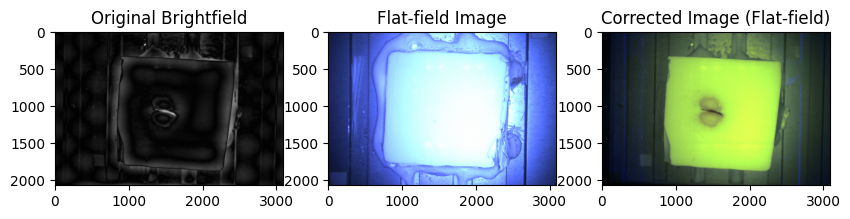

In [412]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def flat_field_correction(brightfield_img, flatfield_img):
    """Perform flat-field correction using a reference flat-field image."""
    # Normalize flat-field image to avoid division by zero
    flatfield_img_normalized = flatfield_img.astype(np.float32) / np.mean(flatfield_img)
    
    # Correct the brightfield image by dividing it by the flat-field image
    corrected_img = brightfield_img.astype(np.float32) / flatfield_img_normalized
    
    # Normalize the corrected image back to 0-255 range
    corrected_img = cv2.normalize(corrected_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    return corrected_img

def fourier_high_pass_correction(brightfield_img, radius=5):
    """Correct uneven illumination using Fourier transform and high-pass filtering."""
    # Convert image to float32 for Fourier transform
    img_float = np.float32(brightfield_img)
    
    # Perform Fourier transform
    dft = cv2.dft(img_float, flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)
    
    # Create a high-pass filter mask
    rows, cols = brightfield_img.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.ones((rows, cols, 2), np.uint8)
    r = radius
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r * r
    mask[mask_area] = 0
    
    # Apply the high-pass filter in the frequency domain
    filtered_dft = dft_shifted * mask
    
    # Inverse Fourier transform to get the corrected image
    f_ishift = np.fft.ifftshift(filtered_dft)
    corrected_img = cv2.idft(f_ishift)
    corrected_img = cv2.magnitude(corrected_img[:,:,0], corrected_img[:,:,1])
    
    # Normalize the result
    corrected_img = cv2.normalize(corrected_img, None, 0, 255, cv2.NORM_MINMAX)
    
    return corrected_img.astype(np.uint8)

# Apply Fourier-based correction
ff_corrected_img = fourier_high_pass_correction(cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_RGB2GRAY))


# brightfield_r = cv2.cvtColor(specimen_bfiw_img[:,:,0], cv2.COLOR_RGB2GRAY)
# brightfield_g = cv2.cvtColor(specimen_bfiw_img[:,:,1], cv2.COLOR_RGB2GRAY)
# brightfield_b = cv2.cvtColor(specimen_bfiw_img[:,:,2], cv2.COLOR_RGB2GRAY)
brightfield_r = specimen_bfiw_img[:,:,0]
brightfield_g = specimen_bfiw_img[:,:,1]
brightfield_b = specimen_bfiw_img[:,:,2]

# Apply flat-field correction
# corrected_img_r = flat_field_correction(brightfield_r, flatfield_img=flatfield_bfiw_img[:,:,0])
# corrected_img_g = flat_field_correction(brightfield_g, flatfield_img=flatfield_bfiw_img[:,:,1])
corrected_img_b = flat_field_correction(brightfield_b, flatfield_img=flatfield_bfiw_img[:,:,2])

# Combine the corrected channels
corrected_img = cv2.merge([brightfield_r, brightfield_g, corrected_img_b])

# Display results
plt.figure(figsize=(10,5))
plt.subplot(1,3,1), plt.imshow(ff_corrected_img, cmap='gray'), plt.title('Original Brightfield')
plt.subplot(1,3,2), plt.imshow(flatfield_bfiw_img, cmap='gray'), plt.title('Flat-field Image')
plt.subplot(1,3,3), plt.imshow(corrected_img, cmap='gray'), plt.title('Corrected Image (Flat-field)')
plt.show()


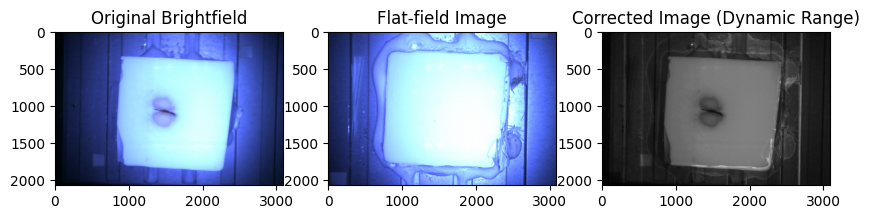

In [413]:
def adaptive_dynamic_range_flat_field_correction(brightfield_img, flatfield_img, intensity_range=(5, 250)):
    """Perform adaptive flat-field correction while preserving dynamic range."""
    # Normalize the flatfield image
    flatfield_img_normalized = flatfield_img.astype(np.float32) / np.mean(flatfield_img)
    
    # Analyze the intensity histogram of the brightfield image
    hist, bin_edges = np.histogram(brightfield_img, bins=256, range=(0, 255))
    hist_cdf = np.cumsum(hist) / np.sum(hist)  # Cumulative distribution function (CDF)
    
    # Determine the lower and upper intensity bounds for correction
    lower_bound = np.searchsorted(hist_cdf, intensity_range[0] / 255.0) / 255.0
    upper_bound = np.searchsorted(hist_cdf, intensity_range[1] / 255.0) / 255.0
    
    # Scale flat-field correction based on intensity bounds
    correction_strength = np.interp(brightfield_img.astype(np.float32) / 255.0, [lower_bound, upper_bound], [0.5, 1.5])
    
    # Apply flat-field correction with dynamic adjustment
    corrected_img = (brightfield_img.astype(np.float32) / flatfield_img_normalized) * correction_strength
    
    # Normalize the result to the 0-255 range
    corrected_img = cv2.normalize(corrected_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    return corrected_img

# Apply adaptive dynamic range flat-field correction
corrected_img = adaptive_dynamic_range_flat_field_correction(cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_RGB2GRAY), cv2.cvtColor(flatfield_bfiw_img, cv2.COLOR_RGB2GRAY))

# Display results
plt.figure(figsize=(10,5))
plt.subplot(1,3,1), plt.imshow(specimen_bfiw_img, cmap='gray'), plt.title('Original Brightfield')
plt.subplot(1,3,2), plt.imshow(flatfield_bfiw_img, cmap='gray'), plt.title('Flat-field Image')
plt.subplot(1,3,3), plt.imshow(corrected_img, cmap='gray'), plt.title('Corrected Image (Dynamic Range)')
plt.show()


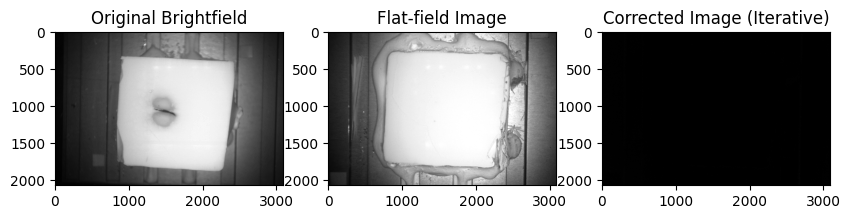

In [417]:
def iterative_flat_field_correction(brightfield_img, flatfield_img, iterations=30, smoothing_kernel=3):
    """Perform iterative flat-field correction with refinement."""
    # Normalize the flatfield image
    flatfield_img_normalized = flatfield_img.astype(np.float32) / np.mean(flatfield_img)
    
    corrected_img = brightfield_img.astype(np.float32) / flatfield_img_normalized
    
    for i in range(iterations):
        # Smooth the corrected image to estimate residual background illumination
        residual_background = cv2.GaussianBlur(corrected_img, (smoothing_kernel, smoothing_kernel), 0)
        
        # Adjust the corrected image by subtracting the residual background
        corrected_img = corrected_img - residual_background
        
        # Ensure no negative values after subtraction
        corrected_img = np.clip(corrected_img, 0, None)
    
    # Normalize the result to the 0-255 range
    corrected_img = cv2.normalize(corrected_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    return corrected_img

# Apply iterative flat-field correction
corrected_img = iterative_flat_field_correction(cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_RGB2GRAY), cv2.cvtColor(flatfield_bfiw_img, cv2.COLOR_RGB2GRAY))

# Display results
plt.figure(figsize=(10,5))
plt.subplot(1,3,1), plt.imshow(cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_RGB2GRAY), cmap='gray'), plt.title('Original Brightfield')
plt.subplot(1,3,2), plt.imshow(cv2.cvtColor(flatfield_bfiw_img, cv2.COLOR_RGB2GRAY), cmap='gray'), plt.title('Flat-field Image')
plt.subplot(1,3,3), plt.imshow(corrected_img, cmap='gray'), plt.title('Corrected Image (Iterative)')
plt.show()


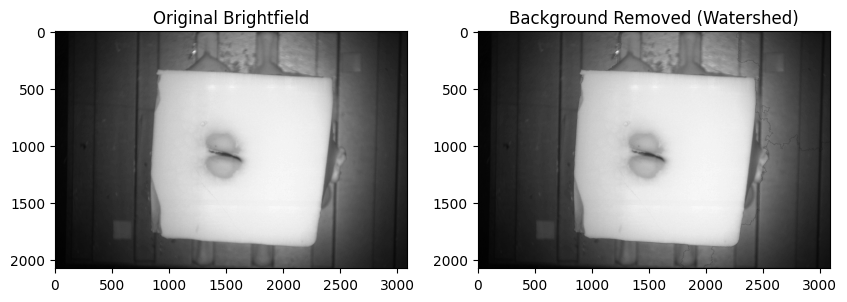

In [419]:
def background_removal_watershed(brightfield_img):
    """Remove background using watershed segmentation."""
    # Apply adaptive threshold to create an initial binarized image
    _, binary_img = cv2.threshold(brightfield_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal (morphological operations)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=10)
    
    # Distance transform and marker creation
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    
    # Mark background
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(binary_img, sure_fg)
    
    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    
    # Apply watershed
    img = cv2.cvtColor(brightfield_img, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(img, markers)
    
    # Mark background as zero
    img[markers == -1] = [0, 0, 0]
    
    return img[:,:,0]  # Return grayscale segmented image

# Apply background removal using watershed segmentation
removed_background = background_removal_watershed(cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_RGB2GRAY))

# Display results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1), plt.imshow(cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_RGB2GRAY), cmap='gray'), plt.title('Original Brightfield')
plt.subplot(1,2,2), plt.imshow(removed_background, cmap='gray'), plt.title('Background Removed (Watershed)')
plt.show()


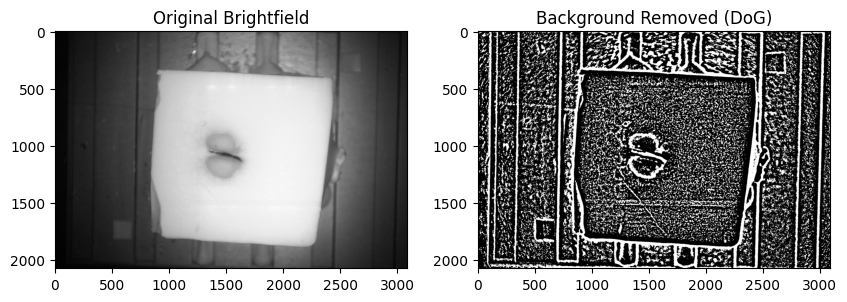

In [420]:
def background_removal_dog(brightfield_img, kernel1=15, kernel2=75):
    """Remove background using the Difference of Gaussian (DoG) method."""
    # Apply Gaussian blur with two different kernel sizes
    blurred1 = cv2.GaussianBlur(brightfield_img, (kernel1, kernel1), 0)
    blurred2 = cv2.GaussianBlur(brightfield_img, (kernel2, kernel2), 0)
    
    # Subtract the two blurred images (Difference of Gaussians)
    dog_result = blurred1 - blurred2
    
    # Threshold to isolate the foreground
    _, binarized_foreground = cv2.threshold(dog_result, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return binarized_foreground

# Apply background removal using Difference of Gaussian
removed_background = background_removal_dog(cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_RGB2GRAY))

# Display results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1), plt.imshow(cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_RGB2GRAY), cmap='gray'), plt.title('Original Brightfield')
plt.subplot(1,2,2), plt.imshow(removed_background, cmap='gray'), plt.title('Background Removed (DoG)')
plt.show()


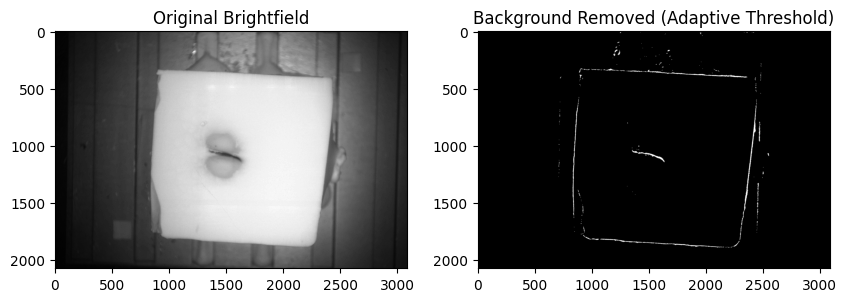

In [447]:
def background_removal_adaptive_threshold(brightfield_img, block_size=51, C=10):
    """Remove background using adaptive thresholding."""
    # Apply adaptive thresholding
    binarized_foreground = cv2.adaptiveThreshold(brightfield_img, 255, 
                                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                                 cv2.THRESH_BINARY_INV, 
                                                 block_size, C)
    
    # Optionally remove small noise using morphological operations
    kernel = np.ones((3, 3), np.uint8)
    binarized_foreground = cv2.morphologyEx(binarized_foreground, cv2.MORPH_OPEN, kernel)
    
    return binarized_foreground

# Apply background removal using adaptive thresholding
removed_background = background_removal_adaptive_threshold(cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_RGB2GRAY))

# Display results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1), plt.imshow(cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_RGB2GRAY), cmap='gray'), plt.title('Original Brightfield')
plt.subplot(1,2,2), plt.imshow(removed_background, cmap='gray'), plt.title('Background Removed (Adaptive Threshold)')
plt.show()


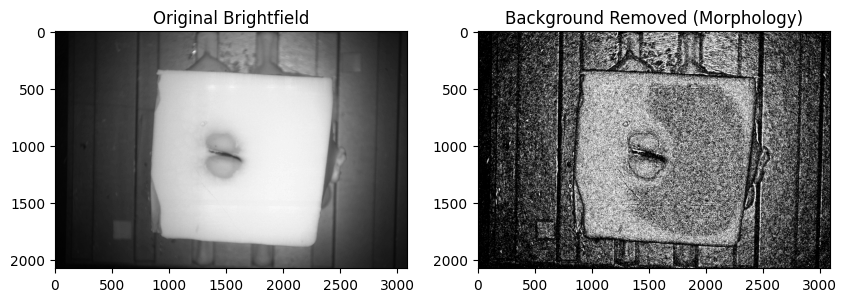

In [448]:
import cv2
import numpy as np

def background_removal_morphology(brightfield_img, kernel_size=15):
    """Remove background using morphological opening to estimate background."""
    # Create a structuring element (kernel) for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    # Perform morphological opening to estimate the background
    background = cv2.morphologyEx(brightfield_img, cv2.MORPH_OPEN, kernel)
    
    # Subtract the background from the original image
    foreground = cv2.subtract(brightfield_img, background)
    
    # Threshold to isolate the specimen more clearly (optional)
    _, binarized_foreground = cv2.threshold(foreground, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return binarized_foreground

# Apply background removal using morphology
removed_background = background_removal_morphology(cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_RGB2GRAY))

# Display results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1), plt.imshow(cv2.cvtColor(specimen_bfiw_img, cv2.COLOR_RGB2GRAY), cmap='gray'), plt.title('Original Brightfield')
plt.subplot(1,2,2), plt.imshow(removed_background, cmap='gray'), plt.title('Background Removed (Morphology)')
plt.show()


In [ ]:
def post_process_morphology(binary_img, kernel_size=5):
    """Apply morphological operations to refine the foreground segmentation."""
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Perform closing to remove small background regions
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
    
    # Optionally, perform opening to remove small foreground artifacts
    opened_img = cv2.morphologyEx(closed_img, cv2.MORPH_OPEN, kernel)
    
    return opened_img


def normalize_intensity(image):
    """Normalize image intensities to enhance contrast and suppress background gradients."""
    norm_img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return norm_img


def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8,8)):
    """Apply CLAHE to enhance local contrast."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_img = clahe.apply(image)
    return clahe_img


from skimage.segmentation import active_contour

def refine_contour_with_snakes(binary_img, init_contour):
    """Refine tissue segmentation using active contours (snakes)"""
    refined_contour = active_contour(binary_img, init_contour)
    return refined_contour

    
def background_removal_pipeline(image):
    # Step 1: Normalize intensities
    norm_img = normalize_intensity(image)
    
    # Step 2: Apply CLAHE for local contrast enhancement
    clahe_img = apply_clahe(norm_img)
    
    # Step 3: Apply Difference of Gaussian (DoG)
    blurred1 = cv2.GaussianBlur(clahe_img, (15, 15), 0)
    blurred2 = cv2.GaussianBlur(clahe_img, (75, 75), 0)
    dog_img = blurred1 - blurred2
    
    # Step 4: Threshold DoG result
    _, binarized_foreground = cv2.threshold(dog_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Step 5: Apply post-processing with morphological operations
    refined_foreground = post_process_morphology(binarized_foreground)
    
    # Step 6: Optional contour refinement with active contours
    # init_contour = ... # Define an initial contour
    # refined_contour = refine_contour_with_snakes(refined_foreground, init_contour)
    
    return refined_foreground

# Apply the pipeline
final_result = background_removal_pipeline(brightfield_img)

# Display the final result
plt.imshow(final_result, cmap='gray')
plt.title('Background Removed with DoG + Refinements')
plt.show()


In [ ]:
def darkfield_masking(darkfield_img, threshold=30):
    """Generate a background mask using the darkfield image."""
    _, mask = cv2.threshold(darkfield_img, threshold, 255, cv2.THRESH_BINARY_INV)
    
    return mask

def refine_segmentation_with_mask(dog_img, mask):
    """Refine DoG segmentation using the darkfield background mask."""
    # Apply the mask to the DoG-filtered image to exclude background
    refined_img = cv2.bitwise_and(dog_img, dog_img, mask=mask)
    
    # Threshold the refined image to get a binary segmentation
    _, binarized_img = cv2.threshold(refined_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return binarized_img

def post_process_morphology(binary_img, kernel_size=5):
    """Apply morphological operations to clean up the segmentation."""
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
    opened_img = cv2.morphologyEx(closed_img, cv2.MORPH_OPEN, kernel)
    
    return opened_img

def background_removal_pipeline(brightfield_img, darkfield_img, flatfield_img):
    # Step 1: Correct brightfield image using flatfield
    corrected_brightfield = flatfield_correction(brightfield_img, flatfield_img)
    
    # Step 2: Generate background mask using darkfield image
    background_mask = darkfield_masking(darkfield_img)
    
    # Step 3: Apply Difference of Gaussian (DoG) filter
    dog_img = apply_dog(corrected_brightfield)
    
    # Step 4: Refine the DoG result using the darkfield mask
    refined_segmentation = refine_segmentation_with_mask(dog_img, background_mask)
    
    # Step 5: Clean up segmentation with morphological operations
    final_segmentation = post_process_morphology(refined_segmentation)
    
    return final_segmentation

# Apply the pipeline using brightfield, darkfield, and flatfield images
final_result = background_removal_pipeline(brightfield_img, darkfield_img, flatfield_img)

# Display the final result
plt.imshow(final_result, cmap='gray')
plt.title('Final Segmentation with Background Removed')
plt.show()
